# Lung Cancer

## Get Radiomic Features from LIDC-IDRI

### Imports

In [2]:
import pylidc as pl
from pylidc.utils import consensus
import SimpleITK as sitk
from radiomics import featureextractor
import pandas as pd

### Get the dataset with all the features

In [3]:
%%capture
# Initialize the feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor()

# Get the list of additional features from pl.annotation_feature_names
additional_features = pl.annotation_feature_names

# Query the LIDC-IDRI dataset for scans with annotations
scans_with_annotations = pl.query(pl.Scan).filter(pl.Scan.annotations.any()).all()

# Lists to store the extracted features and patient IDs
features_list = []

# Variable to create unique IDs for the nodules
nodule_id_counter = 1

# Iterating through all scans with annotations
for scan in scans_with_annotations:
    # Get the patient ID
    patient_id = scan.patient_id

    # Clusterize the annotations for the scan and retrieve all annotations
    nods = scan.cluster_annotations()

    # Iterating through all nodules of the patient
    for anns in nods:
        # Check if the current nodule has annotations
        if anns:
            # Convert consensus annotations into a mask
            cmask, _, _ = pl.utils.consensus(anns, clevel=0.5, pad=[(20, 20), (20, 20), (0, 0)])

            # Convert the pixel array to a SimpleITK image
            image = sitk.GetImageFromArray(cmask.astype(float))

            # Extract radiomic features using PyRadiomics
            features = extractor.execute(image, image, label=1)  # Use label 1 for the nodule

            # Add the patient ID to the features
            features['Patient_ID'] = patient_id

            # Add a unique ID for the nodule
            features['Nodule_ID'] = f'Nodule_{nodule_id_counter}'
            nodule_id_counter += 1

            # Add the additional features to the features dictionary
            for feature_name in additional_features:
                # Access the feature values from the annotation
                if hasattr(anns[0], feature_name):
                    features[feature_name] = getattr(anns[0], feature_name)
                else:
                    # Handle cases where the feature is not available
                    features[feature_name] = None

            # Add the features to the list
            features_list.append(features) 

# Create a DataFrame to store the features
features_df = pd.DataFrame(features_list)

# Save the features to a CSV file
features_df.to_csv('radiomic_features_lidc_all_with_additional.csv', index=False)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

## Data Clean-up

In [47]:
#Read and print the features dataset
df = pd.read_csv('radiomic_features_lidc_all_with_additional.csv')
df

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,Nodule_ID,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy
0,v3.1.0,1.23.5,2.3.0,1.3.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},966db6c8d814983bbfe7125907b2ae5008c7994e,3D,"(1.0, 1.0, 1.0)",...,Nodule_1,4,1,6,4,4,1,2,5,3
1,v3.1.0,1.23.5,2.3.0,1.3.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},d750f93365c734f6f1972e806b046bb1a203f47f,3D,"(1.0, 1.0, 1.0)",...,Nodule_2,5,1,6,3,4,1,1,5,3
2,v3.1.0,1.23.5,2.3.0,1.3.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},58d9ee5073ad7215556c1e295a67e9204a623b2d,3D,"(1.0, 1.0, 1.0)",...,Nodule_3,4,1,5,5,5,1,1,5,1
3,v3.1.0,1.23.5,2.3.0,1.3.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},312913e3e22bc6f2e6cffc8abd1120da5fa413fd,3D,"(1.0, 1.0, 1.0)",...,Nodule_4,5,1,4,3,5,2,3,5,4
4,v3.1.0,1.23.5,2.3.0,1.3.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},08706c40effcb9f7489dc9ce0139a265b8dc6048,3D,"(1.0, 1.0, 1.0)",...,Nodule_5,3,1,6,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646,v3.1.0,1.23.5,2.3.0,1.3.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},db18dcbfdf1ebd1c1390db9dd1fbfd85cce4724b,3D,"(1.0, 1.0, 1.0)",...,Nodule_2647,5,1,6,4,4,2,2,5,4
2647,v3.1.0,1.23.5,2.3.0,1.3.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},fe63df501e056c7f875ab771151194481c70a0b1,3D,"(1.0, 1.0, 1.0)",...,Nodule_2648,1,1,6,4,1,1,1,1,4
2648,v3.1.0,1.23.5,2.3.0,1.3.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},e25d0da08cbc45ea3587c9426cc102940176a4de,3D,"(1.0, 1.0, 1.0)",...,Nodule_2649,2,1,6,4,3,1,1,5,3
2649,v3.1.0,1.23.5,2.3.0,1.3.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},5888efc13966913742433819826d00f4d79f0c24,3D,"(1.0, 1.0, 1.0)",...,Nodule_2650,5,1,6,4,5,1,1,5,2


In [48]:
#Check for null values
df.isna().sum()

diagnostics_Versions_PyRadiomics    0
diagnostics_Versions_Numpy          0
diagnostics_Versions_SimpleITK      0
diagnostics_Versions_PyWavelet      0
diagnostics_Versions_Python         0
                                   ..
margin                              0
lobulation                          0
spiculation                         0
texture                             0
malignancy                          0
Length: 140, dtype: int64

In [49]:
#Check if there are columns with only one value
df.nunique().tolist()

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 2651,
 1,
 1,
 1339,
 2334,
 1,
 1,
 2651,
 1,
 1339,
 1856,
 951,
 6,
 2651,
 2651,
 2651,
 2570,
 2570,
 2651,
 325,
 394,
 314,
 658,
 2347,
 2651,
 2650,
 2650,
 2650,
 951,
 1,
 1,
 951,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 951,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2647,
 2483,
 2536,
 2648,
 951,
 1,
 1,
 2641,
 2641,
 2641,
 1,
 2650,
 2650,
 2650,
 1668,
 1,
 1,
 1,
 2651,
 2651,
 2651,
 1,
 2651,
 2651,
 2651,
 2546,
 2651,
 2651,
 2651,
 2651,
 6,
 1,
 1,
 1,
 962,
 962,
 962,
 1,
 7,
 9,
 962,
 962,
 962,
 9,
 951,
 48,
 1,
 1,
 1,
 1,
 1,
 875,
 2651,
 5,
 4,
 6,
 5,
 5,
 5,
 5,
 5,
 5]

In [50]:
#Get all columns with only one value
unique_value_counts = df.nunique()
columns_with_single_unique_value = unique_value_counts[unique_value_counts == 1].index
print(columns_with_single_unique_value)

Index(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing',
       'diagnostics_Image-original_Minimum',
       'diagnostics_Image-original_Maximum',
       'diagnostics_Mask-original_Spacing', 'original_firstorder_10Percentile',
       'original_firstorder_90Percentile', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_Range',
       'original_firstorder_RobustMeanAbsoluteDeviation',
       'original_fir

In [51]:
#Drop the selected columns
df.drop(columns=columns_with_single_unique_value,inplace=True)

In [52]:
#Drop columns with tuples and IDs
df.drop(df.columns[0], axis=1, inplace=True)
df.drop(df.columns[0], axis=1, inplace=True)
df.drop(df.columns[1], axis=1, inplace=True)
df.drop(df.columns[1], axis=1, inplace=True)
df.drop(df.columns[1], axis=1, inplace=True)
df.drop(df.columns[3], axis=1, inplace=True)
df.drop(df.columns[3], axis=1, inplace=True)
df.drop(df.columns[3], axis=1, inplace=True)
df.drop("Patient_ID", axis=1, inplace=True)
df.drop("Nodule_ID", axis=1, inplace=True)

In [53]:
#Get the count of each value in malignancy column
df["malignancy"].value_counts()

3    989
2    728
1    418
4    301
5    215
Name: malignancy, dtype: int64

In [54]:
# Transform values of the malignancy column to 0 or 1
df = df[df['malignancy'] != 3]
df.loc[df['malignancy'].isin([1, 2]), 'malignancy'] = 0
df.loc[df['malignancy'].isin([4, 5]), 'malignancy'] = 1

In [55]:
#Get the count of each value in malignancy column
df["malignancy"].value_counts()

0    1146
1     516
Name: malignancy, dtype: int64

In [56]:
# Normalizing the columns using Min-Max scaling
df = df.drop(columns=df.select_dtypes(include=['object']))
df = (df - df.min()) / (df.max() - df.min())

In [57]:
new_column_names = [
    'Mean',
    'VoxelNum',
    'VolumeNum',
    'Flatness',
    'LeastAxisLength',
    'MajorAxisLength',
    'DiameterColumn',
    'DiameterRow',
    'DiameterSlice',
    'Max3DDiameter',
    'MeshVolume',
    'MinorAxisLength',
    'Sphericity',
    'SurfaceArea',
    'SurfaceVolRatio',
    'VoxelVol',
    'Energy',
    'TotalEnergy',
    'DiffEntropy',
    'JointEntropy',
    'SumEntropy',
    'DependEntropy',
    'DependNonUniformity',
    'DependNonUniformityNorm',
    'DependVariance',
    'GrayLevelNonUniformity',
    'LargeDependEmphasis',
    'LargeDependHighGLEmphasis',
    'LargeDependLowGLEmphasis',
    'SmallDependEmphasis',
    'SmallDependHighGLEmphasis',
    'SmallDependLowGLEmphasis',
    'GLNonUniformity',
    'LongRunEmphasis',
    'LongRunHighGLEmphasis',
    'LongRunLowGLEmphasis',
    'RunEntropy',
    'RunLengthNonUniformity',
    'RunLenNonUniformityNorm',
    'RunPercentage',
    'RunVariance',
    'ShortRunEmphasis',
    'ShortRunHighGLEmphasis',
    'ShortRunLowGLEmphasis',
    'GLNonUniformity_GLSZM',
    'LargeAreaEmphasis',
    'LargeAreaHighGLEmphasis',
    'LargeAreaLowGLEmphasis',
    'SizeZoneNonUniformity',
    'SizeZoneNonUniformityNorm',
    'SmallAreaEmphasis',
    'SmallAreaHighGLEmphasis',
    'SmallAreaLowGLEmphasis',
    'ZoneEntropy',
    'ZonePercentage',
    'ZoneVariance',
    'Subtlety',
    'InternalStructure',
    'Calcification',
    'Sphericity',
    'Margin',
    'Lobulation',
    'Spiculation',
    'Texture',
    'Malignancy'
]

# Assign the new column names to the DataFrame
df.columns = new_column_names

In [58]:
df

,Mean,VoxelNum,VolumeNum,Flatness,LeastAxisLength,MajorAxisLength,DiameterColumn,DiameterRow,DiameterSlice,Max3DDiameter,...,ZoneVariance,Subtlety,InternalStructure,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy
2,0.053140,0.000640,0.000,0.318505,0.046066,0.049688,0.051377,0.047941,0.035367,0.041411,...,0.000000,0.75,0.0,0.8,1.00,1.00,0.00,0.00,1.0,0.0
3,0.495832,0.080333,0.125,0.238381,0.181580,0.434161,0.583195,0.584977,0.407555,0.576524,...,0.026006,1.00,0.0,0.6,0.50,1.00,0.25,0.50,1.0,1.0
4,0.111337,0.011385,0.000,0.655440,0.208073,0.157364,0.214484,0.160674,0.121130,0.156802,...,0.000000,0.50,0.0,1.0,1.00,1.00,1.00,1.00,1.0,1.0
5,0.048397,0.000221,0.000,0.000000,0.000000,0.039630,0.017126,0.034395,0.034143,0.029710,...,0.000000,0.25,0.0,1.0,0.75,0.75,1.00,1.00,1.0,0.0
6,0.198602,0.035831,0.000,0.287303,0.178511,0.346693,0.326940,0.407476,0.356124,0.364519,...,0.000000,1.00,0.0,1.0,0.75,1.00,1.00,0.75,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2644,0.223184,0.006222,0.000,0.254244,0.081595,0.159531,0.154843,0.176383,0.158087,0.164250,...,0.000000,1.00,0.0,0.4,1.00,0.75,0.25,0.00,1.0,0.0
2646,0.074199,0.007060,0.000,0.412680,0.127934,0.152723,0.167938,0.121156,0.144438,0.144847,...,0.000000,1.00,0.0,1.0,0.75,0.75,0.25,0.25,1.0,1.0
2647,0.144706,0.013635,0.000,0.756811,0.242330,0.159074,0.195612,0.163207,0.128635,0.151536,...,0.000000,0.00,0.0,1.0,0.75,0.00,0.00,0.00,0.0,1.0
2649,0.052095,0.001589,0.000,0.272650,0.069720,0.118897,0.073299,0.060726,0.066457,0.092676,...,0.000000,1.00,0.0,1.0,0.75,1.00,0.00,0.00,1.0,0.0


# Data Analysis

## Imports

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

## Data Overview and Cleaning

In [16]:
df.head()

,diagnostics_Image-original_Mean,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,...,original_glszm_ZoneVariance,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy
2,0.053140,0.000640,0.000,0.318505,0.046066,0.049688,0.051377,0.047941,0.035367,0.041411,...,0.000000,0.75,0.0,0.8,1.00,1.00,0.00,0.00,1.0,0.0
3,0.495832,0.080333,0.125,0.238381,0.181580,0.434161,0.583195,0.584977,0.407555,0.576524,...,0.026006,1.00,0.0,0.6,0.50,1.00,0.25,0.50,1.0,1.0
4,0.111337,0.011385,0.000,0.655440,0.208073,0.157364,0.214484,0.160674,0.121130,0.156802,...,0.000000,0.50,0.0,1.0,1.00,1.00,1.00,1.00,1.0,1.0
5,0.048397,0.000221,0.000,0.000000,0.000000,0.039630,0.017126,0.034395,0.034143,0.029710,...,0.000000,0.25,0.0,1.0,0.75,0.75,1.00,1.00,1.0,0.0
6,0.198602,0.035831,0.000,0.287303,0.178511,0.346693,0.326940,0.407476,0.356124,0.364519,...,0.000000,1.00,0.0,1.0,0.75,1.00,1.00,0.75,1.0,1.0


In [17]:
# checking for null values in columns
missing_values = df.isnull().sum()

columns_with_missing = missing_values[missing_values > 0]
print(missing_values)

diagnostics_Image-original_Mean        0
diagnostics_Mask-original_VoxelNum     0
diagnostics_Mask-original_VolumeNum    0
original_shape_Flatness                0
original_shape_LeastAxisLength         0
                                      ..
margin                                 0
lobulation                             0
spiculation                            0
texture                                0
malignancy                             0
Length: 65, dtype: int64


In [18]:
column_names = df.columns
print(column_names)

Index(['diagnostics_Image-original_Mean', 'diagnostics_Mask-original_VoxelNum',
       'diagnostics_Mask-original_VolumeNum', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'original_firstorder_Energy',
       'original_firstorder_TotalEnergy', 'original_glcm_DifferenceEntropy',
       'original_glcm_JointEntropy', 'original_glcm_SumEntropy',
       'original_gldm_DependenceEntropy',
       'original_gldm_DependenceNonUniformity',
       'original_gldm_DependenceNonUniformityNormalized',
       'original_gldm_DependenceVariance',
       'origi

TypeError: unsupported operand type(s) for /: 'str' and 'int'

## Data Distribution

/home/margarida/miniconda3/envs/CERQUEIRA/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


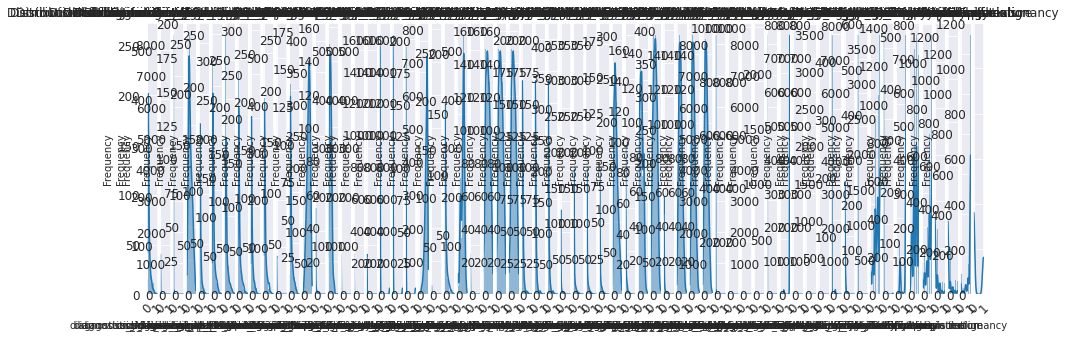

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create distribution plots for all columns (assuming they are all numerical)
# Adjust the number of subplots based on the number of columns
num_plots = len(df.columns)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(15, 5))

# Create histograms for all columns
for i, column in enumerate(df.columns):
    sns.histplot(df[column], ax=axes[i], kde=True)  # Use sns.histplot for a histogram with a KDE curve
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)

    # Increase the font size for x and y-axis labels
    axes[i].tick_params(axis='both', labelsize=12)  # Adjust the font size (e.g., 12)

plt.tight_layout()
plt.show()


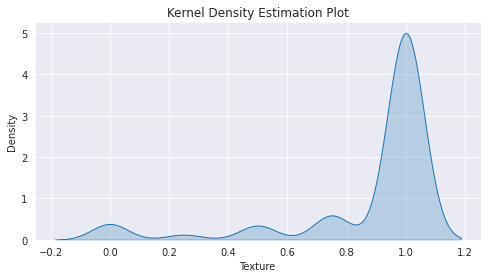

In [37]:
# Kernel Density Estimation (KDE) Plot
plt.figure(figsize=(8, 4))
sns.kdeplot(df['texture'], shade=True)
plt.title('Kernel Density Estimation Plot')
plt.xlabel('Texture')
plt.show()

In [39]:
# Violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(data=df, x='density', y='texture')
plt.title('Violin Plot of Pixel Intensity by Class')
plt.xlabel('density')
plt.ylabel('Texture')
plt.show()


ValueError: Could not interpret input 'density'

<Figure size 576x288 with 0 Axes>

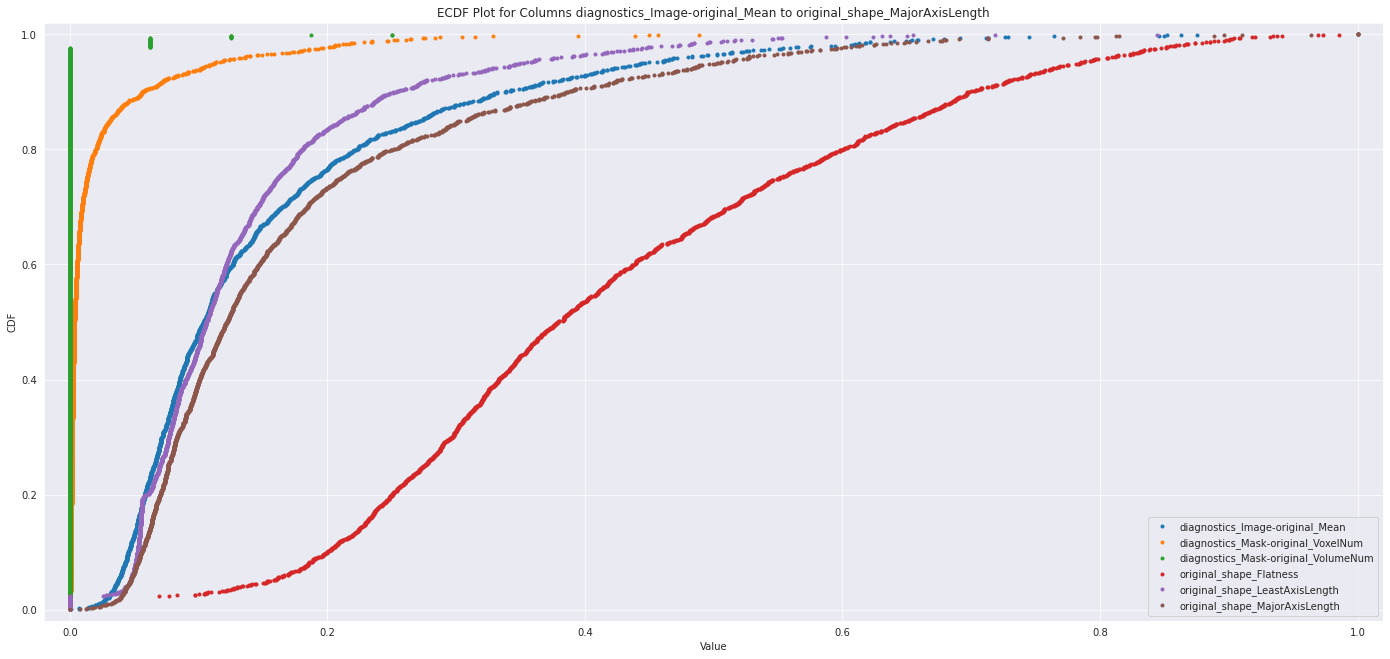

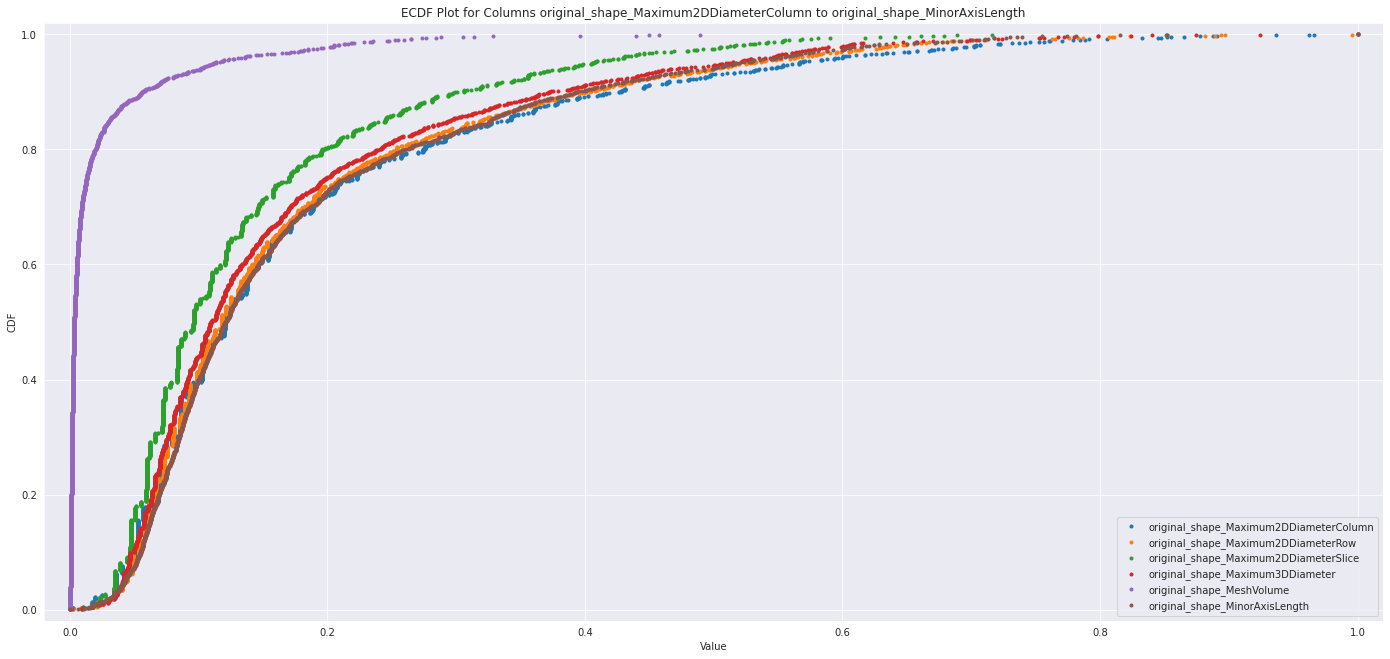

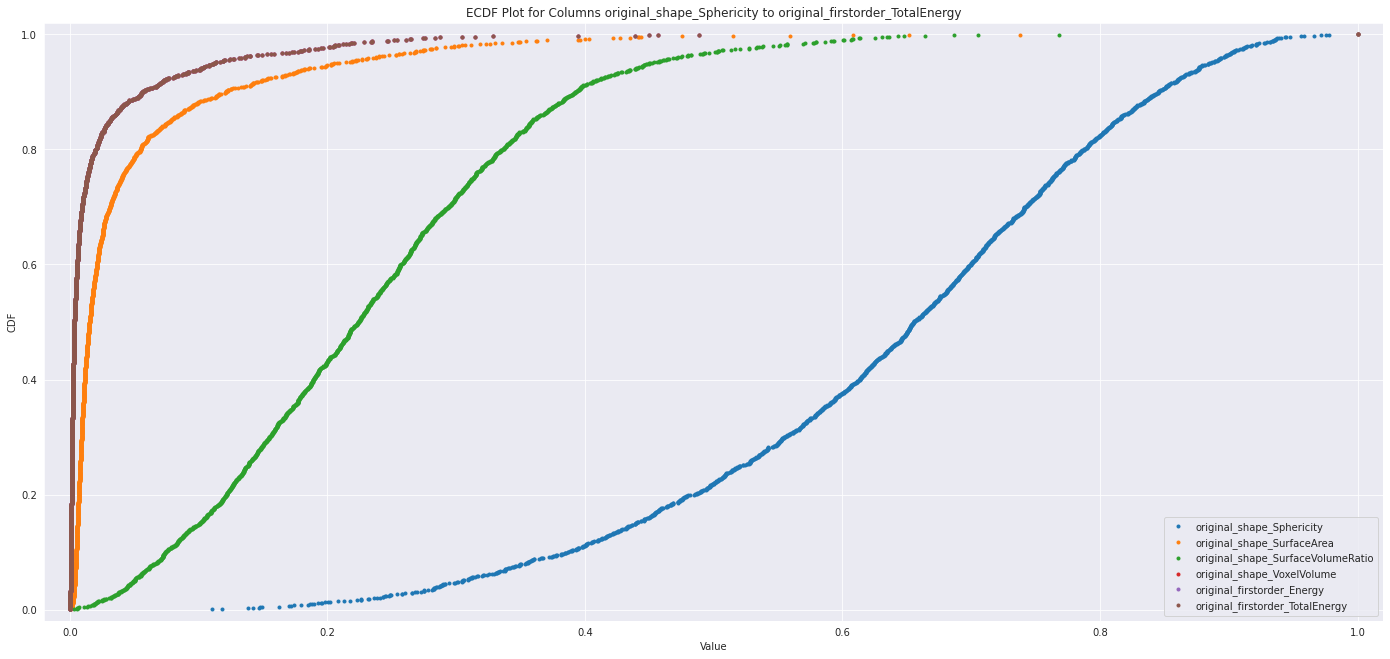

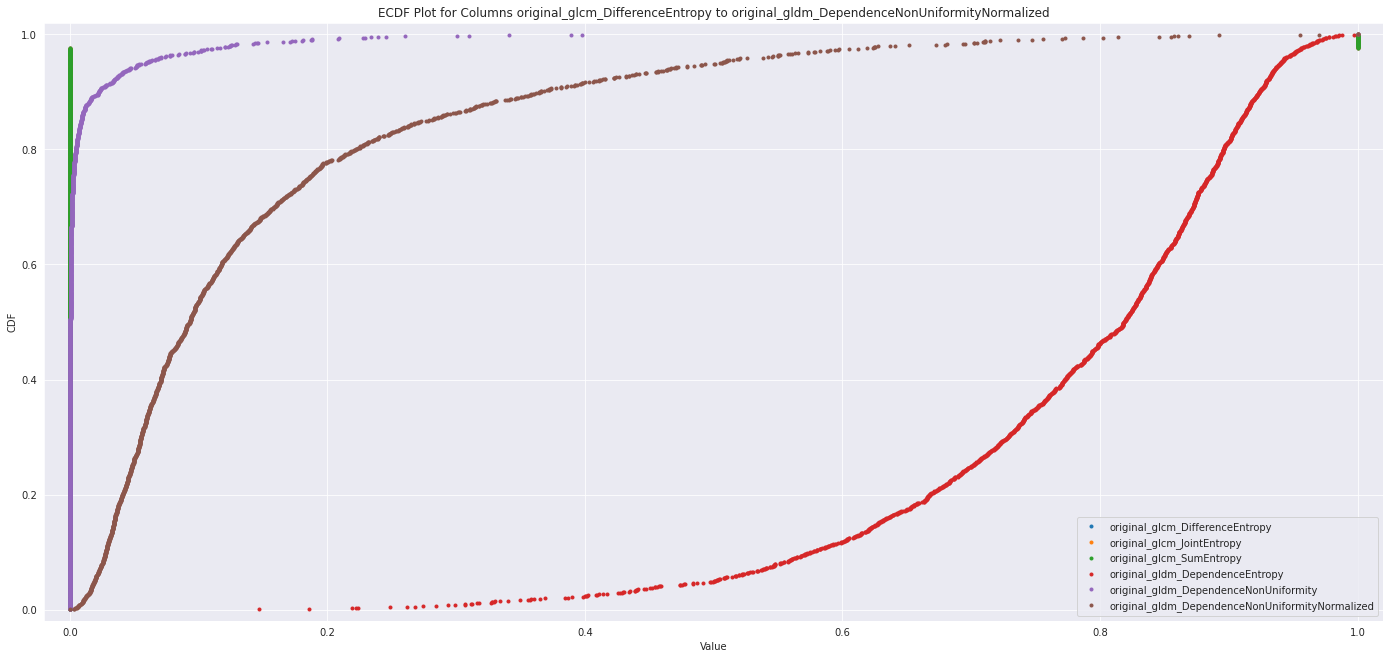

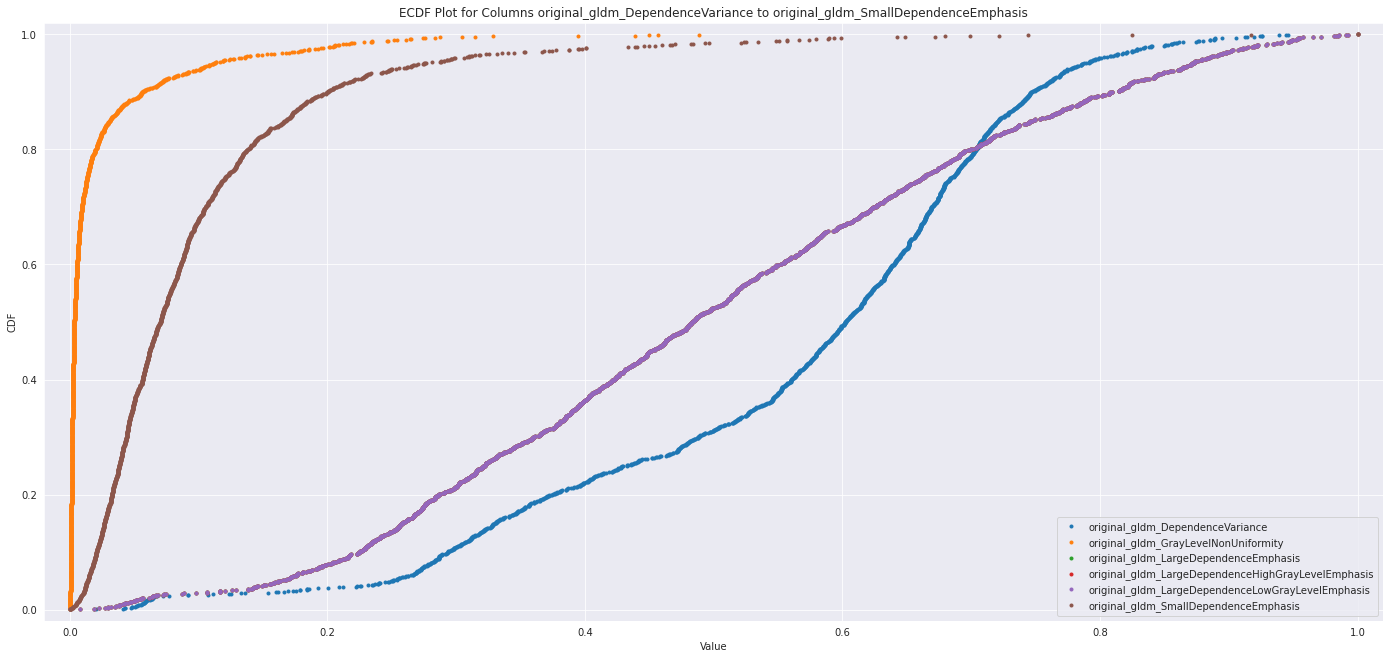

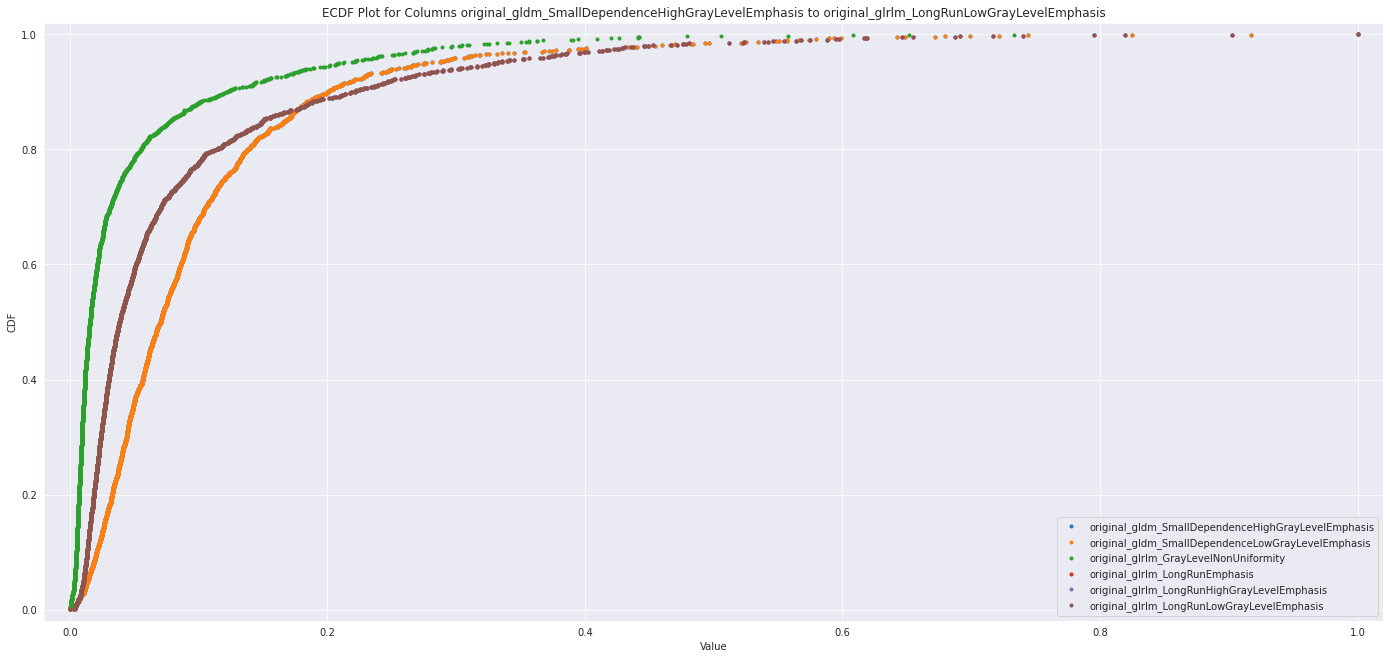

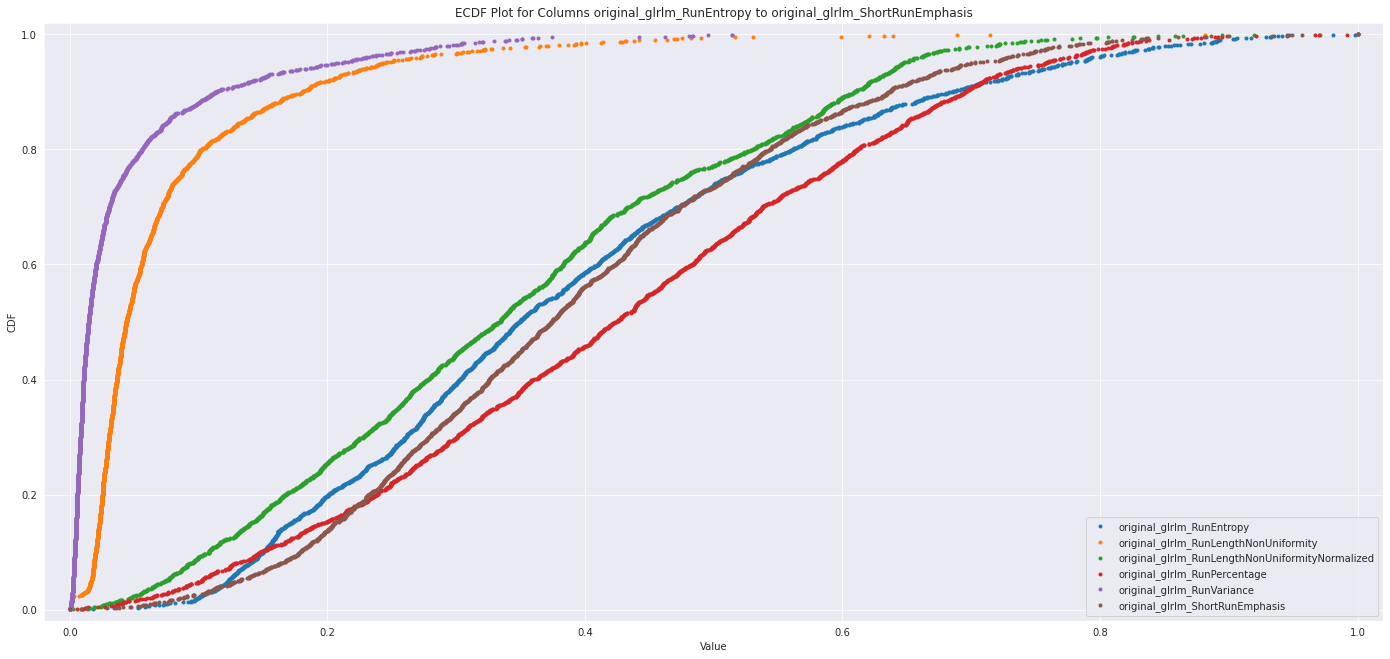

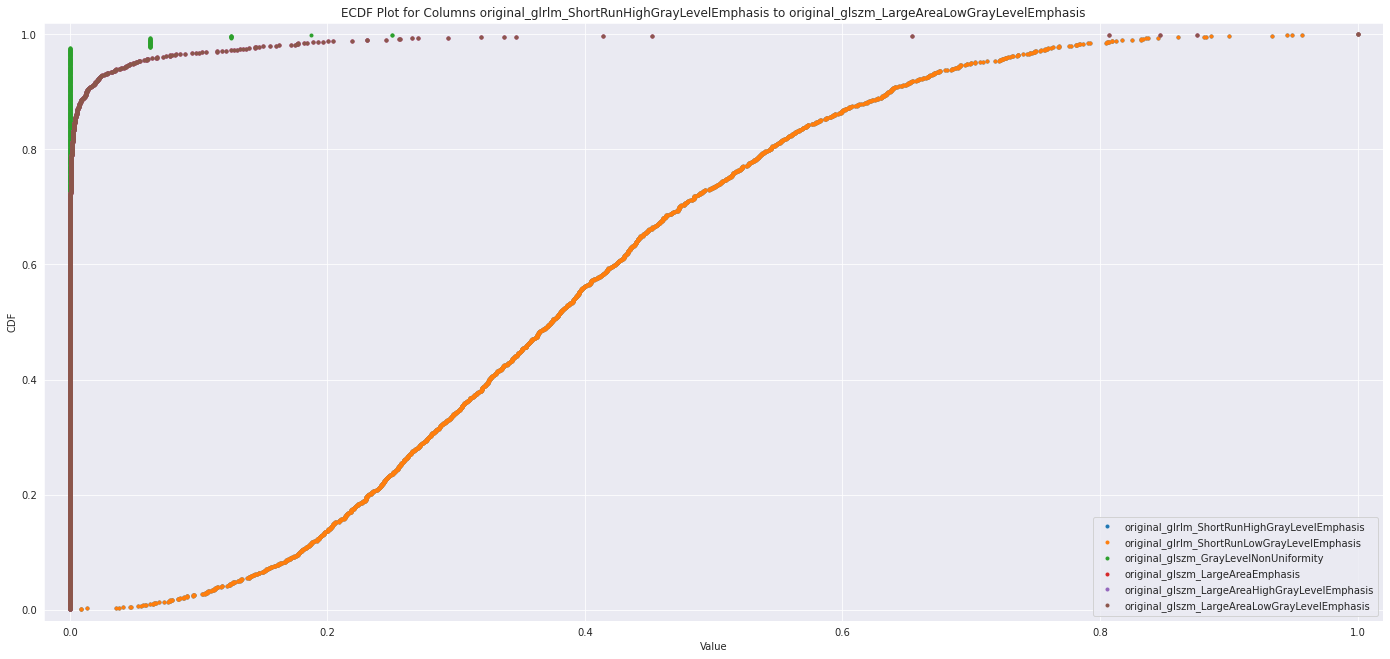

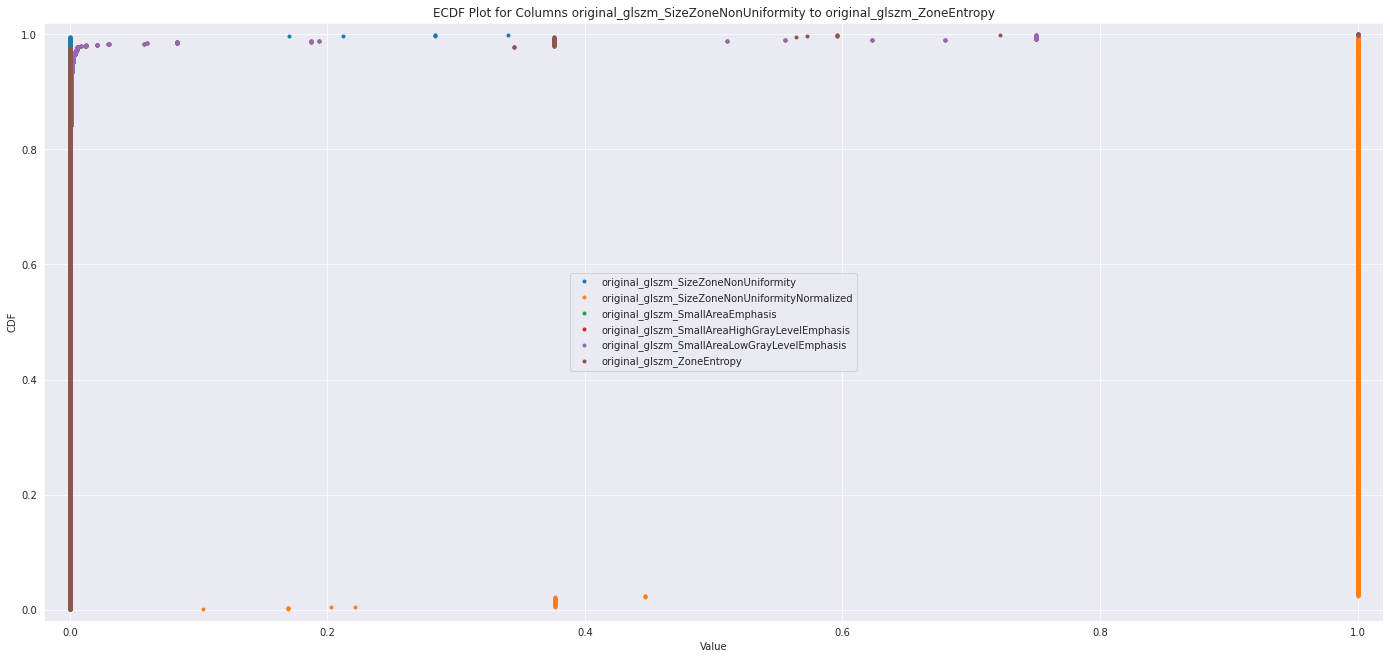

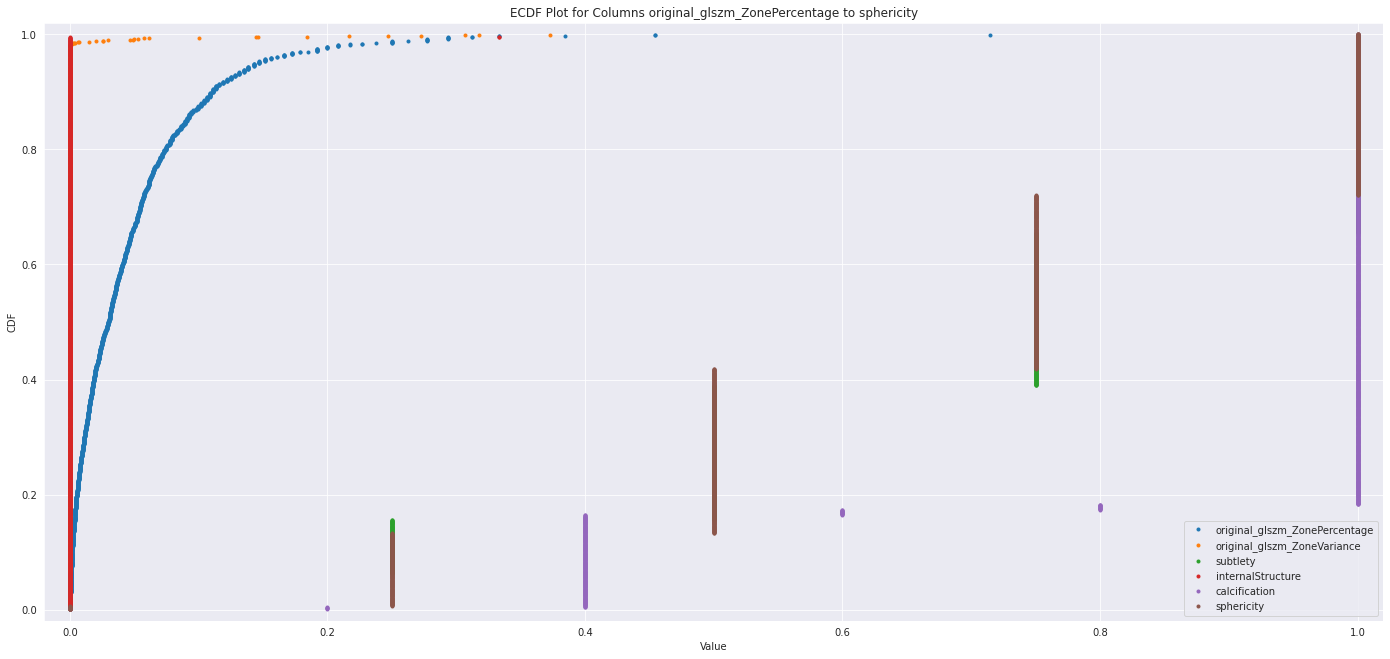

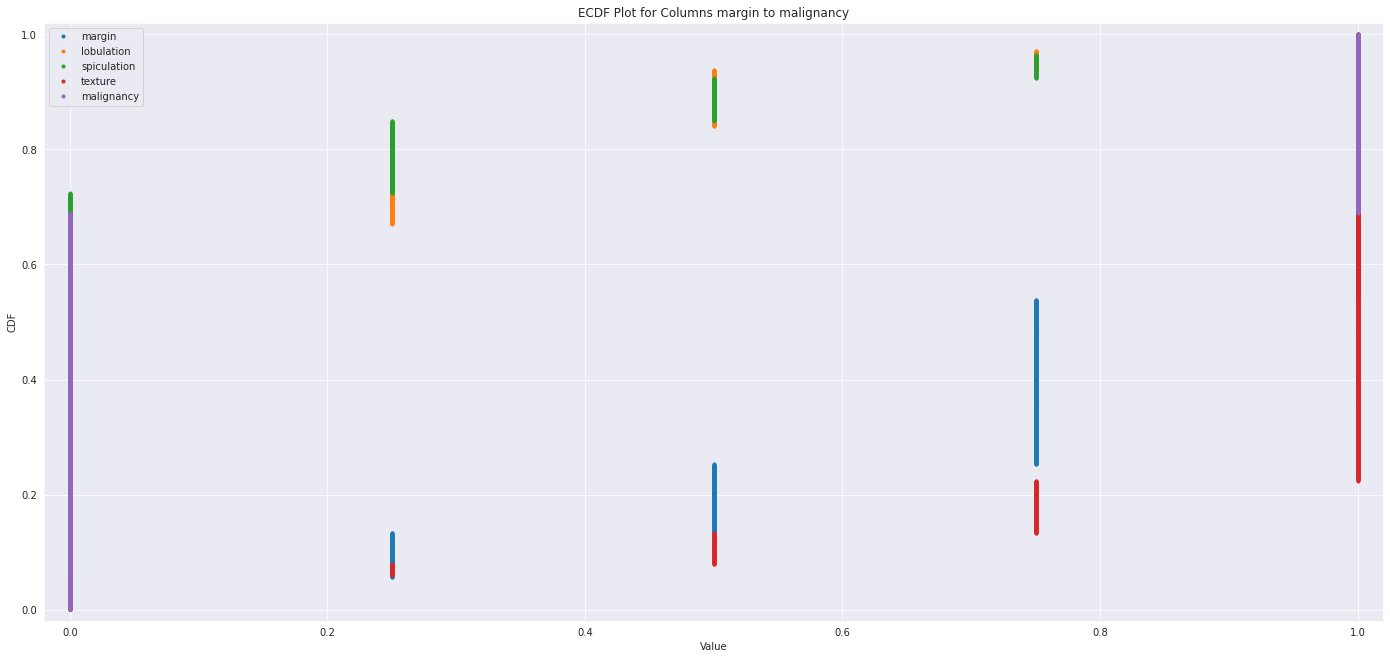

In [36]:
# Empirical Cumulative Distribution Function (ECDF) Plot columns_per_plot = 3
columns_per_plot = 6
# Function to create ECDF plots for a group of columns
def create_ecdf_plots(columns):
    plt.figure(figsize=(24, 11))
    
    for col in columns:
        x = np.sort(df[col])
        y = np.arange(1, len(x) + 1) / len(x)
        plt.plot(x, y, marker='.', linestyle='none', label=col)
    
    plt.title(f'ECDF Plot for Columns {columns[0]} to {columns[-1]}')
    plt.xlabel('Value')
    plt.ylabel('CDF')
    plt.legend()
    plt.margins(0.02)
    plt.show()

# Loop to create ECDF plots for groups of columns
for i in range(0, len(column_names), columns_per_plot):
    columns_to_plot = column_names[i:i + columns_per_plot]
    create_ecdf_plots(columns_to_plot)

## Correlation Analysis

In [41]:
df.select_dtypes(include=['object'])
numeric_columns = df.select_dtypes(exclude=['object'])
correlation_matrix = numeric_columns.corr()

print(correlation_matrix)

                                     diagnostics_Image-original_Mean  \
diagnostics_Image-original_Mean                             1.000000   
diagnostics_Mask-original_VoxelNum                          0.691023   
diagnostics_Mask-original_VolumeNum                         0.162129   
original_shape_Flatness                                    -0.172298   
original_shape_LeastAxisLength                              0.600104   
...                                                              ...   
margin                                                     -0.195251   
lobulation                                                  0.299151   
spiculation                                                 0.330476   
texture                                                    -0.084963   
malignancy                                                  0.498105   

                                     diagnostics_Mask-original_VoxelNum  \
diagnostics_Image-original_Mean                             

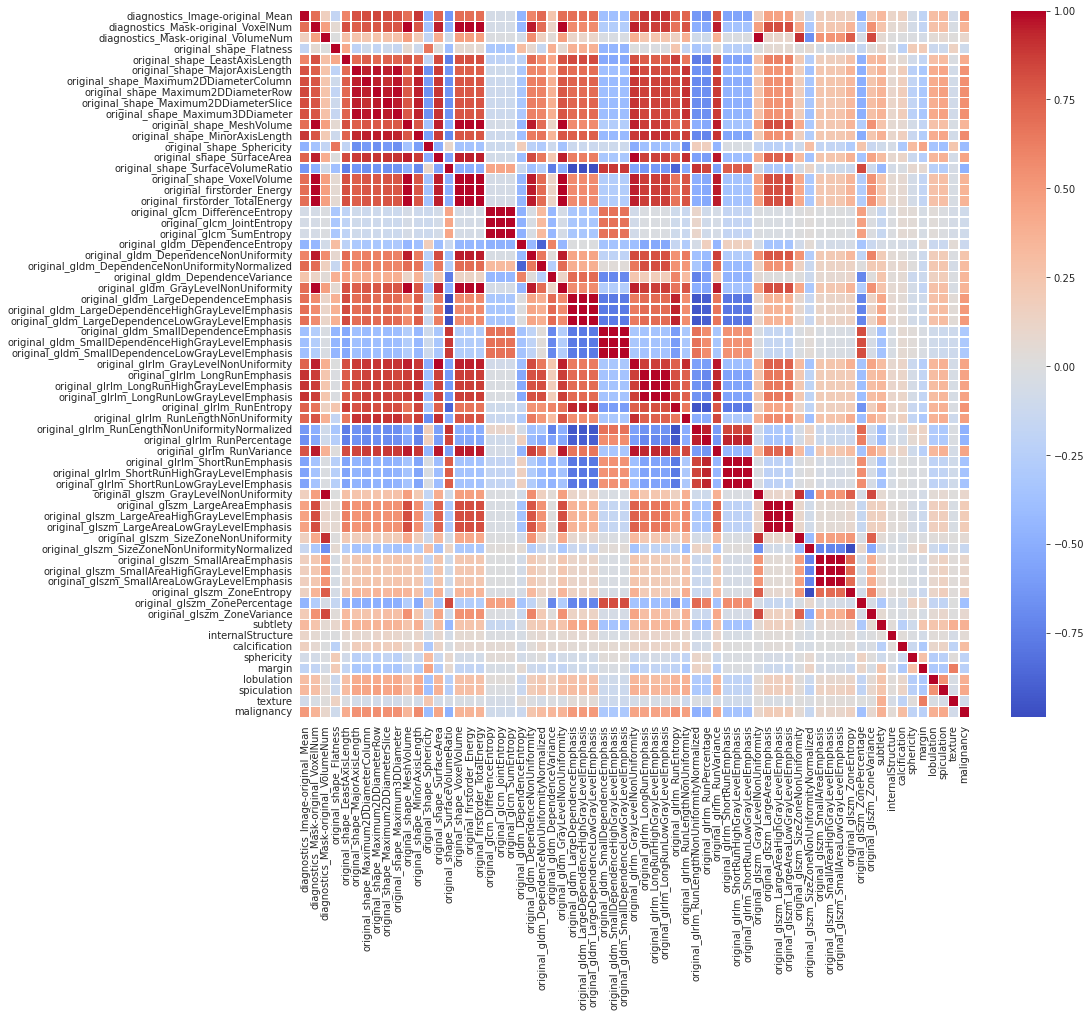

In [42]:
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()

In [43]:
threshold = 0.7

strong_correlations = correlation_matrix[
    (correlation_matrix > threshold) & (correlation_matrix < 1)
    ]

print(strong_correlations)

                                     diagnostics_Image-original_Mean  \
diagnostics_Image-original_Mean                                  NaN   
diagnostics_Mask-original_VoxelNum                               NaN   
diagnostics_Mask-original_VolumeNum                              NaN   
original_shape_Flatness                                          NaN   
original_shape_LeastAxisLength                                   NaN   
...                                                              ...   
margin                                                           NaN   
lobulation                                                       NaN   
spiculation                                                      NaN   
texture                                                          NaN   
malignancy                                                       NaN   

                                     diagnostics_Mask-original_VoxelNum  \
diagnostics_Image-original_Mean                             

## Feature Relationships

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create pair plots to explore relationships between numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64'])  # Select numerical features

# Customize the pair plot based on your preferences
sns.set(style="ticks")
pair_plot = sns.pairplot(numerical_features, diag_kind="kde")

# You can add additional customization options as needed, such as hue, markers, etc.
# Example:
# pair_plot = sns.pairplot(numerical_features, diag_kind="kde", hue="target_variable", markers=["o", "s", "D"])

# Show the pair plot
plt.show()


## Feature Importance

## Outliers and Anomalies

In [46]:
# Calculate the Z-scores for each numerical feature------------------------------------not working
numeric_columns = df.select_dtypes(exclude=['object'])

z_scores = np.abs(stats.zscore(numeric_columns))

# Define a threshold for considering data points as outliers (e.g., Z-score > 3)
threshold = 3

# Identify and remove outliers
outliers = (z_scores > threshold).any(axis=1)
cleaned_data = df[~outliers]
cap_value = 3

# Alternatively, you can choose to impute or transform outliers instead of removing them
# Example for capping outliers to a specific value
cleaned_data['texture'] = np.where(z_scores > threshold, cap_value, cleaned_data['texture'])


ValueError: operands could not be broadcast together with shapes (1662,65) () (1324,) 

## Data Preprocessing and Feature Engineering

## Summary and Insights

In [ ]:
df.select_dtypes(include=['object'])

In [ ]:
numeric_columns = df.select_dtypes(exclude=['object'])
correlation_matrix = numeric_columns.corr()

print(correlation_matrix)

In [ ]:

plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()

In [ ]:
correlation_matrix = numeric_columns.corr()

threshold = 0.7

strong_correlations = correlation_matrix[
    (correlation_matrix > threshold) & (correlation_matrix < 1)
]

print(strong_correlations)

## Classification

### Imports

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
df

In [ ]:
X = df.iloc[:, :-1]  # Features (all columns except the last one)
y = df.iloc[:, -1]   # Target (the last column)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def testing(test,pred):
    accuracy = accuracy_score(test, pred)
    report = classification_report(test, pred, zero_division=1)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)


#### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of trees (n_estimators)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [ ]:
testing(y_test,y_pred)

#### Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVR
from sklearn.svm import SVC

#### Naive Bayes

##### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gauss = GaussianNB()
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)

In [ ]:
testing(y_test,y_pred)

##### MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mult = MultinomialNB()
mult.fit(X_train, y_train)
y_pred = mult.predict(X_test)

In [ ]:
testing(y_test,y_pred)

##### BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bern = BernoulliNB()
bern.fit(X_train, y_train)
y_pred = bern.predict(X_test)

In [ ]:
testing(y_test,y_pred)

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lregress = LogisticRegression()
lregress.fit(X_train, y_train)
y_pred = lregress.predict(X_test)

In [ ]:
testing(y_test,y_pred)

#### XGBoost/LightGBM (Gradient Boosting)

##### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
testing(y_test,y_pred)

##### LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
testing(y_test,y_pred)